In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn # scikit-learn kutubxonasi
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn import metrics 

# Bizning ushbu modelni qurishdagi vazifamiz **`Y house price of unit area`**(Birlik maydonining uy narxi ) ni bashorat qilish 

## **Ta'rif**

- `X1 transaction date`	--->  *Tranzaktsiya sanasi (masalan, 2013.250=2013-mart, 2013.500=2013-iyun va boshqalar)*

- `X2 house age`	--->  *Uy yoshi (birlik: yil)*

- `X3 distance to the nearest MRT station`	--->  *Eng yaqin MRT stantsiyasigacha bo'lgan masofa (birlik: metr)*

- `X4 number of convenience stores`	--->  *Piyoda yashash doirasidagi do'konlar soni*

- `X5 latitude`	--->  *Geografik koordinata, kenglik (birlik: daraja)*

- `X6 longtitude`	--->  *Geografik koordinata, uzunlik (birlik: daraja)*

- `Y house price of unit area`	--->  *Birlik maydonining uy narxi (10000 Yangi Tayvan Dollari/Ping, bu erda Ping mahalliy birlikdir, 1 Ping = 3,3 metr kvadrat), masalan, 29,3 = 293 000 Yangi Tayvan Dollari/`Ping`*

In [22]:
url = "https://github.com/farkhod-developer/Datasets_Practice/blob/main/Real_estate_valuation_data_set.xlsx?raw=True"
df = pd.read_excel(url)
df.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


Ko'rib turganingizdek dataset ustunlar nomlari birtoz tartibsiz holda ekan, ushbu ustunlar nomlarini tartiblab o'zgartirib oldik

In [23]:
columns = ['transaction_date', 'house_age', 'distance_MRT_station', 'number_stores', 'latitude', 'longitude', 'house_price']
df.columns = columns
df.head()

,transaction_date,house_age,distance_MRT_station,number_stores,latitude,longitude,house_price
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


datasetimiz `414` ta qator `7` ta ustundan iborat ekan

In [24]:
df.shape

(414, 7)

ma'lumotlarimizda `NaN` qiymatlar yo'q ekan

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   transaction_date      414 non-null    float64
 1   house_age             414 non-null    float64
 2   distance_MRT_station  414 non-null    float64
 3   number_stores         414 non-null    int64  
 4   latitude              414 non-null    float64
 5   longitude             414 non-null    float64
 6   house_price           414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


Takrorlanuvchi qiymatlar ham yo'q ekan

In [26]:
df.duplicated().sum()

0

In [27]:
df.describe()

,transaction_date,house_age,distance_MRT_station,number_stores,latitude,longitude,house_price
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [28]:
df['house_price'].value_counts()

42.5    4
40.3    4
29.3    4
40.6    4
37.4    4
       ..
55.9    1
22.9    1
21.5    1
55.1    1
63.9    1
Name: house_price, Length: 270, dtype: int64

In [29]:
df['house_price'].describe()

count    414.000000
mean      37.980193
std       13.606488
min        7.600000
25%       27.700000
50%       38.450000
75%       46.600000
max      117.500000
Name: house_price, dtype: float64

`house_price`(uylar narxlari) ustuniga nisbatan barcha ustunlarning korrelyatsiyasi, eng yaxshi korrelyatsiya `eng yaqin metrogacha bo'lgan masofa` ekan

In [30]:
df.corrwith(df['house_price']).abs().sort_values(ascending=False)

house_price             1.000000
distance_MRT_station    0.673613
number_stores           0.571005
latitude                0.546307
longitude               0.523287
house_age               0.210567
transaction_date        0.087529
dtype: float64

`Normalizatsiya`ning vizualizatsiya ko'rinishi

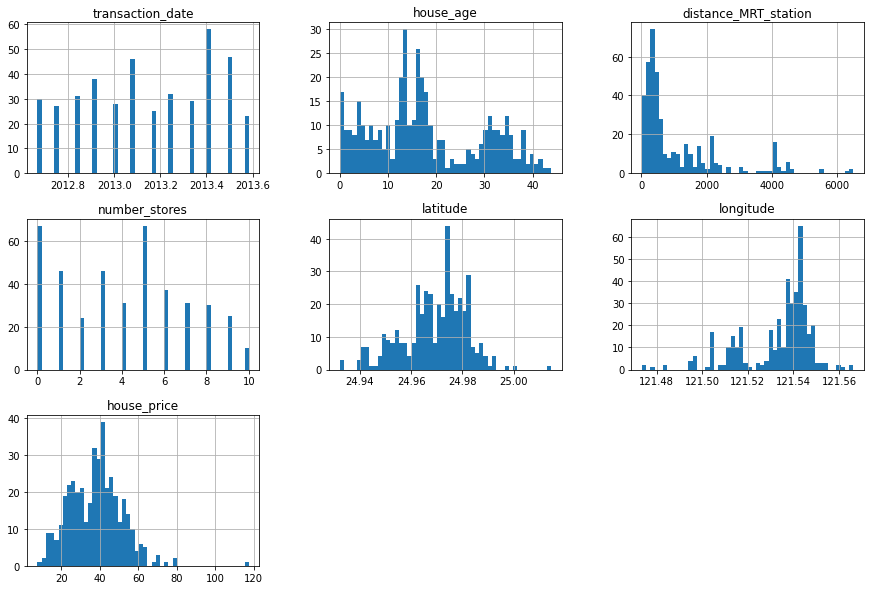

In [31]:
df.hist(bins=50, figsize=(15,10))
plt.show()

Mana `house_price` ustunining normalizatsiyasi yaxshi holatda ekan, faqat ba'zi joylariga ishlov berishimiz kerak

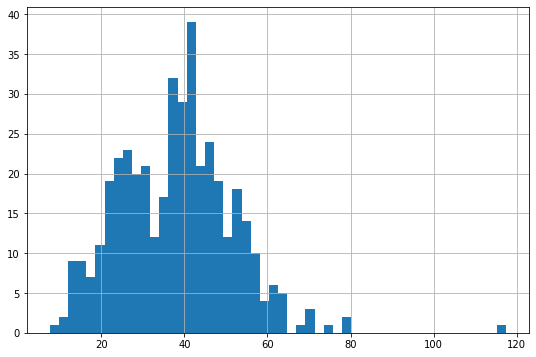

In [32]:
df['house_price'].hist(bins=50, figsize=(9,6))
plt.show()

asl `DF` ga shikast yetmasligi uchun `housing` o'zgaruvchiga nusxa olvolamiz

In [33]:
housing = df.copy()

`house_price` ustunidan `10.0` dan kichik va `61.0` dan katta bo'lgan qiymatlarni olib tashlayapmiz, bu albatta korrelyatsiyani yaxshilashga yordam beradi.  
Ushbu sonlar `Tayvan` davlatining pul bitligi(`Ping`). Bu haqida ma'lumotni yuqorida batafsil aytib o'tganmiz

In [34]:
housing = housing[housing['house_price'] > 10.0]
housing =housing[housing['house_price'] < 61.0]

In [35]:
housing['house_price'].describe()

count    396.000000
mean      36.681818
std       11.750060
min       11.200000
25%       27.225000
50%       37.900000
75%       45.325000
max       60.700000
Name: house_price, dtype: float64

mana endi `normalizatsiya` yaxshiroq holatga keldi

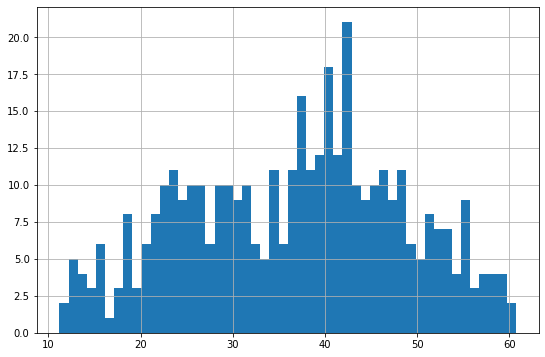

In [36]:
housing['house_price'].hist(bins=50, figsize=(9,6))
plt.show()

`Korrelyatsiyani` ham sezilarli darajada o'sganini ko'rishimiz mumkin

In [37]:
housing.corrwith(housing['house_price']).abs().sort_values(ascending=False)

house_price             1.000000
distance_MRT_station    0.732041
number_stores           0.612782
latitude                0.593502
longitude               0.571465
house_age               0.240067
transaction_date        0.032296
dtype: float64

# Scikit-learn yordamida LR

Avvalo ma'lumotlarni train va testga bo'lib olamiz.

### Train/Test split

Bizda ma'lumotlar kam, shuning uchun 10% test uchun olamiz

In [38]:
train_set, test_set = train_test_split(housing, test_size=0.10, random_state=42)

# Simple Linear Regression

In [39]:
LR_model = linear_model.LinearRegression()

x_train = np.asanyarray(train_set[['distance_MRT_station']])
y_train = np.asanyarray(train_set[['house_price']])

# Modelni tarbiyalaymiz (train)
LR_model.fit(x_train, y_train)

#theta1 va theta0 koeefisentlarni ajratib olamiz 
theta1 = LR_model.coef_[0][0]
theta0 = LR_model.intercept_[0]
print (f'theta1= {theta1}')
print (f'theta0= {theta0}')

theta1= -0.006766729585484215
theta0= 44.13960668125144


$\theta_0$ va $\theta_1$ qiymatlari yordamida to'g'ri chiziq chizamiz

Text(0, 0.5, 'Price')

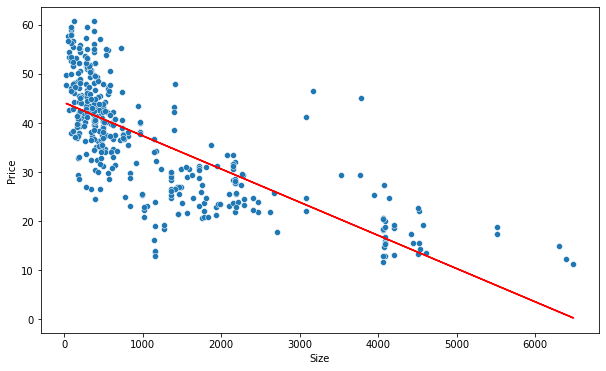

In [40]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=housing, x='distance_MRT_station', y='house_price')
plt.plot(x_train, theta1*x_train + theta0, '-r')
plt.xlabel("Size")
plt.ylabel("Price")

### Modelni baholaymiz

In [41]:
x_test = np.asanyarray(test_set[['distance_MRT_station']])
y_test = np.asanyarray(test_set[['house_price']])

In [42]:
y_predict = LR_model.predict(x_test)

In [43]:
MAE = mean_absolute_error(y_test, y_predict)
RMSE = np.sqrt(mean_squared_error(y_test, y_predict))
print(f"MAE= {MAE}")
print(f"RMSE= {RMSE}")

MAE= 7.069489951722206
RMSE= 9.413874148119627


`MAE`, va `RMSE` xatoliklar ko'rishimiz mumkin, bizda xatolik qancha kam chiqsa natijamiz shuncha yaxshi bo'ladi.  

Boshqa yo'llarini ham sinab ko'ramiz.

# Multiple Linear Regression

### ML

In [44]:

MLR_model = linear_model.LinearRegression()
x_train = np.asanyarray(train_set[['distance_MRT_station','number_stores','latitude','longitude']])
# x_train = np.asanyarray(train_set[['size','max_levels']])
y_train = np.asanyarray(train_set[['house_price']])
MLR_model.fit(x_train, y_train)
# Koeffisientlar (theta1, theta2, ...)
print('Coefficients: ', MLR_model.coef_)
print('theta0:', MLR_model.intercept_) 

Coefficients:  [[-4.03549382e-03  1.02304301e+00  2.08474937e+02  1.44960969e+01]]
theta0: [-6930.15859413]


### Modelni baholaymiz

In [45]:
# x_test = np.asanyarray(test_set[['rooms','size','level','max_levels']])
x_test = np.asanyarray(test_set[['distance_MRT_station','number_stores','latitude','longitude']])
y_test = np.asanyarray(test_set[['house_price']])
y_predict = MLR_model.predict(x_test)

In [46]:
MAE = mean_absolute_error(y_test, y_predict)
RMSE = np.sqrt(mean_squared_error(y_test, y_predict))
print(f"MAE= {MAE}")
print(f"RMSE= {RMSE}")

MAE= 6.872509632266483
RMSE= 9.344606353401057


sezilarni darajada farq bo'lmadi, yana boshqa algoritmlarni ham ko'ramiz, eng optimal yechimni o'zimiz topishimiz kerak.



  ---

---



---





# Pipeline - konveyer

In [47]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

X_train = train_set.drop("house_price", axis=1)
y = train_set["house_price"].copy()

In [48]:
num_pipeline = Pipeline([
          ('std_scaler', StandardScaler())             
])

Yuoqirda biz sonli ustunlar uchun konveyer yaratdik (`num_pipeline`).  


Pipeline 3 ta transformerdan iborat (`imputer`, `atrribs_adder` va `std_scaler`),  bizda `NaN` qiymatlar va `Matnli` ustunlar bo'lmaganlgi sababli faqatgina `std_scaler` dan foydalanamiz.
Bu transformerlarga siz istalgancha nom berishingiz mumkin.


Pipeline ihsga tushrish uchun `.fit_transform()` metodiga murojaat qilamiz.

In [49]:
num_attribs = list(X_train)

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
])

Mana yakuniy, to'liq konveyer tayyor bo'ldi (`full_pipeline`). 

Konveyerni ishga tushirish uchun `.fit_transform()` metodini chaqrisih kifoya.

In [50]:
X_prepared = full_pipeline.fit_transform(X_train)

In [51]:
X_prepared[0:5,:]

array([[-1.12732609, -1.21844389,  0.90511062, -0.36203355, -0.46232084,
        -1.40288558],
       [ 1.26552041, -0.06406947,  2.46521539, -1.40839882, -2.22994431,
        -1.97276669],
       [-0.52911438, -1.48483798, -0.72463353,  0.68433171, -0.26102855,
         0.48434862],
       [ 0.36820302, -0.03743006, -0.51909735, -1.05961039,  0.49687363,
        -0.41619607],
       [ 0.06909734, -0.4192616 , -0.28224825, -1.40839882,  0.63297005,
        -0.55667839]])

Ma'lumotlar ML uchun tayyor.

## Machine Learning  

Bizning maqsadimiz bashorat qilish, buning uchun bir nechta ML algoritmlar mavjud.

# Linear Regression - Chiziqli regressiya  


`sklearn` tarkibidagi `LinearRegression` klassidan yangi model yaratamiz.

In [52]:
LR_model = LinearRegression()

`LinearRegression` bu estimator. Estimatorlar ma'lumotlarni qabul qilib oladi va `.fit()` metodi yordamida ulardan basorat qilishni _o'rganadi_ (machine _learning_)

In [53]:
LR_model.fit(X_prepared, y)

LinearRegression()

Modelni qanday qilib tekshirib ko'rishimiz mumkin? Keling `housing` datasetdan biror qatorni modelga beramiz va chiqqan natijani bizdagi bor natija (label) bilan solishtiramiz.

In [54]:
# tasodifiy 5 ta qatorni ajratib olamiz
test_data = X_train.sample(5)
test_data

,transaction_date,house_age,distance_MRT_station,number_stores,latitude,longitude
271,2012.916667,17.7,451.6419,8,24.96945,121.54490
388,2013.500000,10.4,2251.9380,4,24.95957,121.51353
234,2013.250000,8.0,2216.6120,4,24.96007,121.51361
226,2013.000000,16.5,4082.0150,0,24.94155,121.50381
239,2013.500000,18.1,837.7233,0,24.96334,121.54767


In [55]:
# yuqoridagi qatorlarga mos keluvchi narxlarni ajratib olamiz (biz aynan shu qiymatlarni bashorat qilishimiz kerak)
test_label = y.loc[test_data.index]
test_label

271    26.5
388    27.3
234    23.9
226    12.8
239    29.7
Name: house_price, dtype: float64

`test_data` ni pipelinedan o'tkazib, bizga kerak ko'rinishga keltirib olamiz.

**Ahamiyat bering** bu safgar biz `.transform()` metodini chaqiramiz, sababi `.fit()` metodini avval chaqirgan edik.

In [56]:
test_data_prepared = full_pipeline.transform(test_data)
test_data_prepared

array([[-8.28220054e-01, -1.91084373e-03, -5.12937800e-01,
         1.38190856e+00,  4.37622229e-02,  7.50072254e-01],
       [ 1.26552041e+00, -6.50136480e-01,  9.63923509e-01,
        -1.32451299e-02, -7.61406973e-01, -1.32866851e+00],
       [ 3.68203018e-01, -8.63251757e-01,  9.34944052e-01,
        -1.32451299e-02, -7.20659544e-01, -1.32336729e+00],
       [-5.29114375e-01, -1.08468483e-01,  2.46521539e+00,
        -1.40839882e+00, -2.22994431e+00, -1.97276669e+00],
       [ 1.26552041e+00,  3.36083692e-02, -1.96218411e-01,
        -1.40839882e+00, -4.54171359e-01,  9.33626985e-01]])

Bashorat (predict) qilamiz:

In [57]:
predicted_data = LR_model.predict(test_data_prepared)
predicted_data

array([43.08790117, 32.638666  , 32.80546025, 13.22090292, 33.11256993])

Yuoqirda ko'rib turganingiz bashorat qilingan qiymatlar. Xo'sh, ular real qiymatlardan qanday farq qiladi, solishtiramiz:

In [58]:
pd.DataFrame({'Prognoz':predicted_data, 'Real baxosi': test_label})

,Prognoz,Real baxosi
271,43.087901,26.5
388,32.638666,27.3
234,32.805460,23.9
226,13.220903,12.8
239,33.112570,29.7


### Modelni baholaymiz  


Ko'rib turganingizdek, modelimiz qayerdadur kamroq, qayeradur ko'proq xato bilan bashorat qilgan. 
Lekin model aniqligini baxolash uchun 5 qator yetarli emas. Keling, avvalroq ajratib olgan test set yordamida sinab ko'ramiz:

Avval predictor ustunlarni ajratib olaylik (`house_price`) dan boshqa barcha ustunlar):

In [59]:
X_test = test_set.drop('house_price', axis=1)
X_test

,transaction_date,house_age,distance_MRT_station,number_stores,latitude,longitude
81,2013.000000,30.8,377.79560,6,24.96427,121.53964
289,2013.333333,13.9,289.32480,5,24.98203,121.54348
261,2013.166667,16.2,2288.01100,3,24.95885,121.51359
57,2012.916667,3.5,56.47425,7,24.95744,121.53711
408,2013.416667,18.5,2175.74400,3,24.96330,121.51243
...,...,...,...,...,...,...
85,2012.750000,0.0,338.96790,9,24.96853,121.54413
120,2013.166667,13.3,492.23130,5,24.96515,121.53737
3,2013.500000,13.3,561.98450,5,24.98746,121.54391
19,2012.666667,1.5,23.38284,7,24.96772,121.54102


Label (`house_price`) ustunini ajratib olamiz.

In [60]:
y_test = test_set['house_price'].copy()
y_test

81     36.8
289    44.5
261    24.4
57     53.5
408    28.1
       ... 
85     50.8
120    31.3
3      54.8
19     47.7
181    55.9
Name: house_price, Length: 80, dtype: float64

`test_set` ni ham pipelinedan o'tkazamiz:

In [61]:
X_test_prepared = full_pipeline.transform(X_test)

Bashorat

In [62]:
y_predicted = LR_model.predict(X_test_prepared)

Bashorat va real datani solishtirish uchun avvalgi bo'limda ko'rgan `Root mean square error` (RMSE) dan foydalanamiz:

In [63]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_test, y_predicted)
# RMSE hisoblaymiz
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

7.433070701522758


Demak, `RMSE=7.43Ping` chiqdi. Ya'ni modelimiz uylarni baholashda o'rtacha `7.43 Ping` ga adashayapti. 

# DecisionTree

In [64]:
Tree_model = DecisionTreeRegressor()
Tree_model.fit(X_prepared, y)

DecisionTreeRegressor()

Modelni tekshiramiz:

In [65]:
y_predicted = Tree_model.predict(X_test_prepared)

In [66]:
lin_mse = mean_squared_error(y_test, y_predicted)
# RMSE hisoblaymiz
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

7.113675210466106


Avvalgidan katta farq qilmadi.

# RandomForest

In [67]:
RF_model = RandomForestRegressor()
RF_model.fit(X_prepared, y)

RandomForestRegressor()

Modelni tekshiramiz:

In [68]:
y_predicted = RF_model.predict(X_test_prepared)
lin_mse = mean_squared_error(y_test, y_predicted)
# RMSE hisoblaymiz
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

6.109031567453888


Avvalgidan yaxhsiroq.

# Cross-Validation usuli bilan baholash

Yuqorida biz modelni baholash uchun ma'lumotlarni test va train setlarga ajratdik. 
Bu usulning kamchiligi biz test va train uchun doim bir xil ma'lumotlardan foydalanayapmiz. 

Cross-validation yordamida biz ma'lumotlarni bir necha qismga ajratib, modelni turli qismlar yordamida bir nechta bor train va test qilishimiz mumkin. 

Misol uchun, quyidagi rasmda ma'lumotlarni 5 ga ajratib train va test qilish ko'rsatilgan.

![](https://www.oreilly.com/library/view/machine-learning-quick/9781788830577/assets/b90b29ab-dfe7-4c11-9a2f-321e84f79495.png)

Cross validation uchun ma'lumotlarni train va testga bo'lish shart emas, buni sklearn o'zi qiladi.

In [69]:
X = housing.drop("house_price", axis=1)
y = housing["house_price"].copy()

X_prepared = full_pipeline.transform(X)

Validation natijalarini ko'rsatish uchun sodda funksiya yasab olamiz

In [70]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std.dev:", scores.std())

#### LogisticRegression

In [71]:
scores = cross_val_score(LR_model, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
LR_rmse_scores = np.sqrt(-scores)

In [72]:
display_scores(LR_rmse_scores)

Scores: [6.81108354 5.54383123 6.85314215 8.80081165 5.98568109 6.09366747
 7.33105719 6.38617484 6.07133517 6.46527264]
Mean: 6.634205696070069
Std.dev: 0.8699175505122239


Yuqoridagi bilan deyarli bir xil

#### Decision Tree

In [73]:
scores = cross_val_score(Tree_model, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
LR_rmse_scores = np.sqrt(-scores)
display_scores(LR_rmse_scores)

Scores: [5.75286885 6.29158168 7.14388725 7.69295538 7.39172257 4.8518682
 7.24880627 7.9526322  7.0937224  5.56557643]
Mean: 6.698562121928113
Std.dev: 0.972271553131596


bu ham shunday

#### Random Forest

In [84]:
scores = cross_val_score(RF_model, X_prepared, y, scoring="neg_mean_squared_error", cv=5)
LR_rmse_scores = np.sqrt(-scores)
display_scores(LR_rmse_scores)

Scores: [5.05403367 5.64902373 4.0785765  5.79238688 4.77503292]
Mean: 5.0698107395902365
Std.dev: 0.6208529887194967


Mana eng optimal yechim `Cross Validation` usuli orqali baholangan `Random Forest` algoritmida ko'rishimiz mumkin.!